In [56]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
%matplotlib inline

In [29]:
df = pd.read_csv('../train.csv')
print(df.shape)
df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [30]:
df['month'] = pd.DatetimeIndex(df['datetime']).month
df['day'] = pd.DatetimeIndex(df['datetime']).day
df['dayofweek'] = pd.DatetimeIndex(df['datetime']).dayofweek
df['hour'] = pd.DatetimeIndex(df['datetime']).hour
df = df.drop('datetime', axis=1)
# y = df['count'].copy()
# df = df.drop(['casual','registered','count'], axis=1)
df = df.drop(['casual','registered'], axis=1)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,day,dayofweek,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,1,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,40,1,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,32,1,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,13,1,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,1,1,1,5,4


In [10]:
target = 'count'

In [41]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(
            xgb_param, 
            xgtrain, 
            num_boost_round=alg.get_params()['n_estimators'], 
            nfold=cv_folds,
            metrics='rmse', 
            early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
#     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
#     print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("R2 Score (Train): %f" % metrics.r2_score(dtrain[target].values, dtrain_predictions))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
R2 Score (Train): 0.973562


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=True, subsample=0.8)

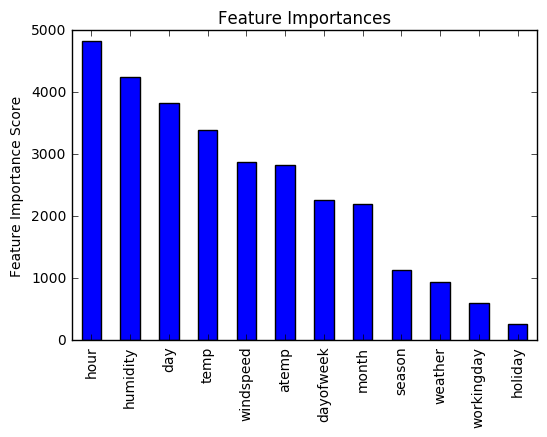

In [65]:
#Choose all predictors except target & IDcols
predictors = [x for x in df.columns if x not in [target]]
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=-1,
 scale_pos_weight=1,
 seed=7)
modelfit(xgb1, df, predictors)

Tune params

In [66]:
param_test1 = {
 'max_depth':range(3,8,1),
 'min_child_weight':range(1,6,1)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(
        objective= 'reg:linear', 
        nthread=-1, 
        seed=7), 
                        param_grid = param_test1, 
                        scoring='r2',
                        n_jobs=-1,
                        iid=False, 
                        cv=5)
gsearch1.fit(df[predictors],df[target])
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 5}, 0.39501544351757378)

In [67]:
param_test2 = {
 'gamma': [i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(
        max_depth=4,
        min_child_weight=5,
        objective='reg:linear', 
        nthread=-1, 
        seed=7), 
                        param_grid = param_test2, 
                        scoring='r2',
                        n_jobs=-1,
                        iid=False, 
                        cv=5)
gsearch1.fit(df[predictors],df[target])
gsearch1.best_params_, gsearch1.best_score_

({'gamma': 0.0}, 0.39501544351757378)


Model Report
R2 Score (Train): 0.857390


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=5, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=True, subsample=1)

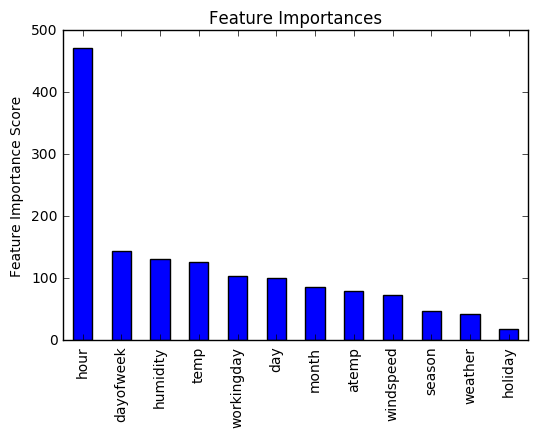

In [68]:
xgb2 = XGBRegressor(
 max_depth=4,
 min_child_weight=5,
 gamma=0,
 objective= 'reg:linear',
 nthread=-1,
 seed=7)
modelfit(xgb2, df, predictors)

In [74]:
param_test3 = {
    'subsample': [i/100.0 for i in range(45,80,5)],
    'colsample_bytree': [i/100.0 for i in range(45,80,5)]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(
        max_depth=4,
        min_child_weight=5,
        gamma=0,
        objective='reg:linear', 
        nthread=-1, 
        seed=7), 
                        param_grid = param_test3, 
                        scoring='r2',
                        n_jobs=-1,
                        iid=False, 
                        cv=5)
gsearch1.fit(df[predictors],df[target])
gsearch1.best_params_, gsearch1.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.6}, 0.41765429742401466)

In [79]:
param_test4 = {
    'reg_alpha':[1e-10, 1e-9, 1e-8]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(
        max_depth=4,
        min_child_weight=5,
        subsample=0.6,
        colsample_bytree=0.6,
        gamma=0,
        objective='reg:linear', 
        nthread=-1, 
        seed=7), 
                        param_grid = param_test4, 
                        scoring='r2',
                        n_jobs=-1,
                        iid=False, 
                        cv=5)
gsearch1.fit(df[predictors],df[target])
gsearch1.best_params_, gsearch1.best_score_

({'reg_alpha': 1e-10}, 0.41765429753548455)


Model Report
R2 Score (Train): 0.849166


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=5, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=1e-10, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=True, subsample=0.6)

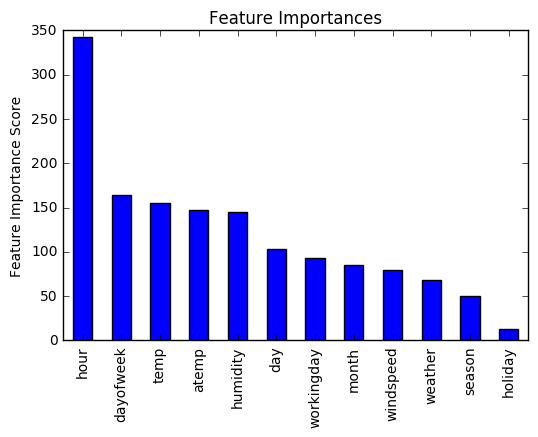

In [81]:
xgb3 = XGBRegressor(
    max_depth=4,
    min_child_weight=5,
    gamma=0,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=1e-10,
    objective= 'reg:linear',
    nthread=-1,
    seed=7)
modelfit(xgb3, df, predictors)


Model Report
R2 Score (Train): 0.918428


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=5, missing=None, n_estimators=5000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=True, subsample=0.6)

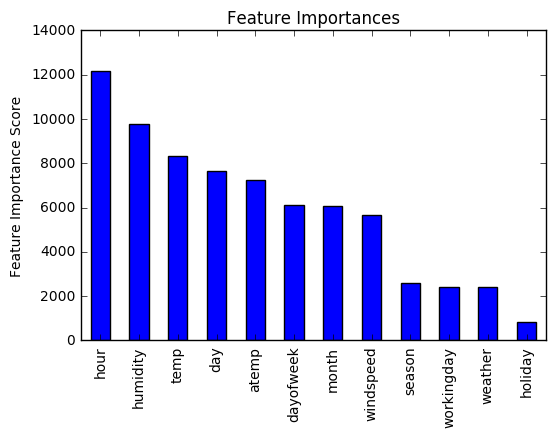

In [87]:
xgb4 = XGBRegressor(
    learning_rate=0.01,
    n_estimators=5000,
    max_depth=4,
    min_child_weight=5,
    gamma=0,
    subsample=0.6,
    colsample_bytree=0.6,
#     reg_alpha=1e-10,
    objective= 'reg:linear',
    nthread=-1,
    seed=7)
modelfit(xgb4, df, predictors)

Test

In [45]:
df_test = pd.read_csv('../test.csv')
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [46]:
dft = df_test.copy()
dft['month'] = pd.DatetimeIndex(dft['datetime']).month
dft['day'] = pd.DatetimeIndex(dft['datetime']).day
dft['dayofweek'] = pd.DatetimeIndex(dft['datetime']).dayofweek
dft['hour'] = pd.DatetimeIndex(dft['datetime']).hour
dft = dft.drop('datetime', axis=1)
dft.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,day,dayofweek,hour
0,1,0,1,1,10.66,11.365,56,26.0027,1,20,3,0
1,1,0,1,1,10.66,13.635,56,0.0000,1,20,3,1
2,1,0,1,1,10.66,13.635,56,0.0000,1,20,3,2
3,1,0,1,1,10.66,12.880,56,11.0014,1,20,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,1,20,3,4


Predict test data

In [86]:
test_pred = xgb4.predict(dft)
test_pred[test_pred < 0] = 0

str_prediction = "datetime,count\n"
for i in range(0, len(test_pred)):
    datetime = df_test['datetime'][i]
    pred = int(round(test_pred[i]))
    str_prediction += "{},{}\n".format(datetime, pred)

# print(str_prediction)
f = open('pred.csv','w')
f.write(str_prediction)
f.close()